In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import stan
import arviz as az # For visualization and loo
#needed for notebook
import nest_asyncio
nest_asyncio.apply()

## Data

In [2]:
df=pd.read_csv('data/erakondaded_rahastamine.csv')
df.shape

(127386, 8)

In [3]:
df.head()

,laekumise_aeg,tululiik,nimi,sünnikuupäev_regkood,summa,periood_erakond,aruande_periood,erakond
0,25.06.2018,Liikmemaks,SVEN SILDNIK,03.01.1964,20,26.09.2018 Eesti Iseseisvuspartei,26.09.2018,Eesti Iseseisvuspartei
1,21.03.2018,Liikmemaks,SVEN SILDNIK,03.01.1964,20,26.09.2018 Eesti Iseseisvuspartei,26.09.2018,Eesti Iseseisvuspartei
2,06.06.2017,Liikmemaks,TÕNIS TULP,20.07.1951,25,10.07.2017 Eesti Iseseisvuspartei,10.07.2017,Eesti Iseseisvuspartei
3,09.01.2017,Rahaline annetus,KARL MARTINSON,30.06.1979,30,13.04.2017 Eesti Iseseisvuspartei,13.04.2017,Eesti Iseseisvuspartei
4,24.03.2016,Rahaline annetus,KARL MARTINSON,30.06.1979,20,11.04.2016 Eesti Iseseisvuspartei,11.04.2016,Eesti Iseseisvuspartei


<Axes: >

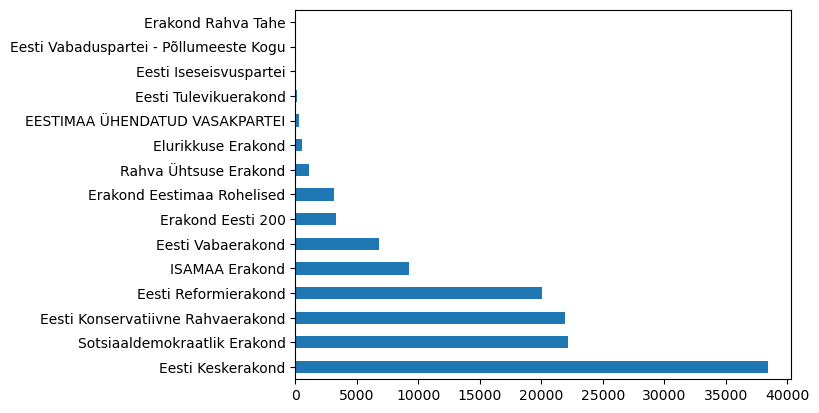

In [4]:
df.erakond.value_counts().plot(kind='barh')

<Axes: ylabel='erakond'>

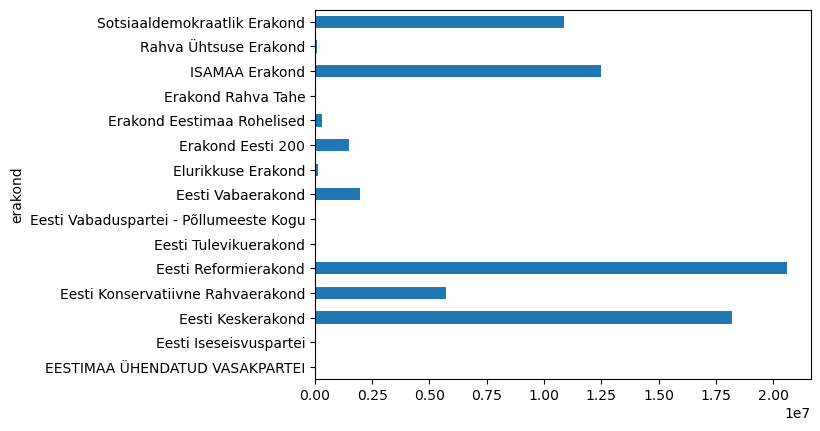

In [5]:
df.groupby('erakond')['summa'].sum().plot(kind='barh')

## Extact dates

In [6]:
df['laekumise_aeg_dt']=pd.to_datetime(df.laekumise_aeg)

/tmp/ipykernel_79/545875471.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['laekumise_aeg_dt']=pd.to_datetime(df.laekumise_aeg)


In [7]:
df.head()

,laekumise_aeg,tululiik,nimi,sünnikuupäev_regkood,summa,periood_erakond,aruande_periood,erakond,laekumise_aeg_dt
0,25.06.2018,Liikmemaks,SVEN SILDNIK,03.01.1964,20,26.09.2018 Eesti Iseseisvuspartei,26.09.2018,Eesti Iseseisvuspartei,2018-06-25
1,21.03.2018,Liikmemaks,SVEN SILDNIK,03.01.1964,20,26.09.2018 Eesti Iseseisvuspartei,26.09.2018,Eesti Iseseisvuspartei,2018-03-21
2,06.06.2017,Liikmemaks,TÕNIS TULP,20.07.1951,25,10.07.2017 Eesti Iseseisvuspartei,10.07.2017,Eesti Iseseisvuspartei,2017-06-06
3,09.01.2017,Rahaline annetus,KARL MARTINSON,30.06.1979,30,13.04.2017 Eesti Iseseisvuspartei,13.04.2017,Eesti Iseseisvuspartei,2017-09-01
4,24.03.2016,Rahaline annetus,KARL MARTINSON,30.06.1979,20,11.04.2016 Eesti Iseseisvuspartei,11.04.2016,Eesti Iseseisvuspartei,2016-03-24


## Plot some dynamics

<Axes: xlabel='laekumise_aeg_dt'>

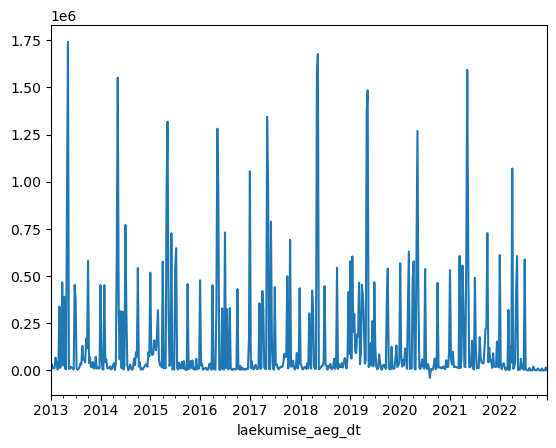

In [8]:
#daily sums
df.set_index('laekumise_aeg_dt').groupby(pd.Grouper(freq='W'))['summa'].sum().plot()

<Axes: xlabel='laekumise_aeg_dt'>

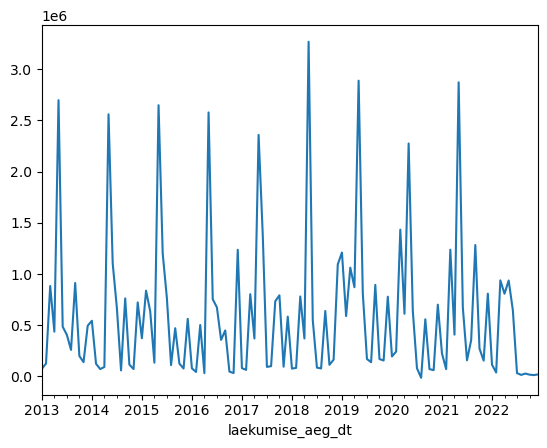

In [9]:
#monthly sums
df.set_index('laekumise_aeg_dt').groupby(pd.Grouper(freq='M'))['summa'].sum().plot()

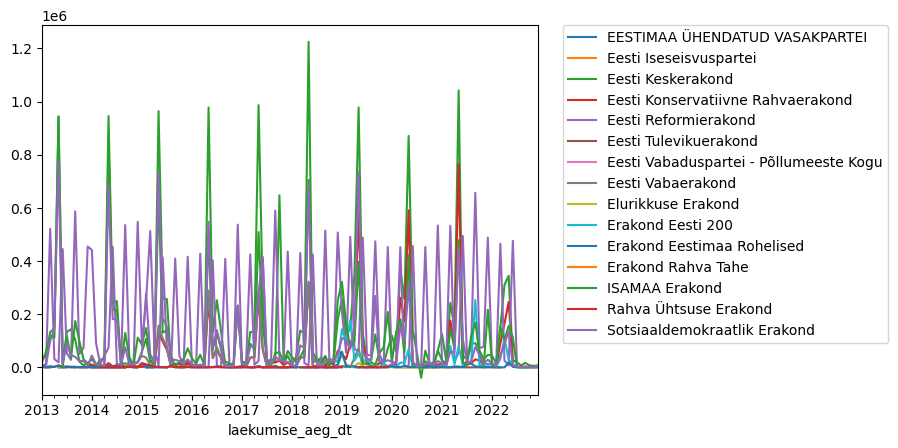

In [10]:
#monthly plus 
df.set_index('laekumise_aeg_dt').groupby([pd.Grouper(freq='M'), 'erakond'])['summa'].sum().unstack().plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [11]:
df_erakond_m=df.set_index('laekumise_aeg_dt').groupby([pd.Grouper(freq='M'), 'erakond'])['summa'].sum().unstack().fillna(0)
df_erakond_m['date']=df_erakond_m.index
df_erakond_m_melt=df_erakond_m.melt(id_vars=['date'])

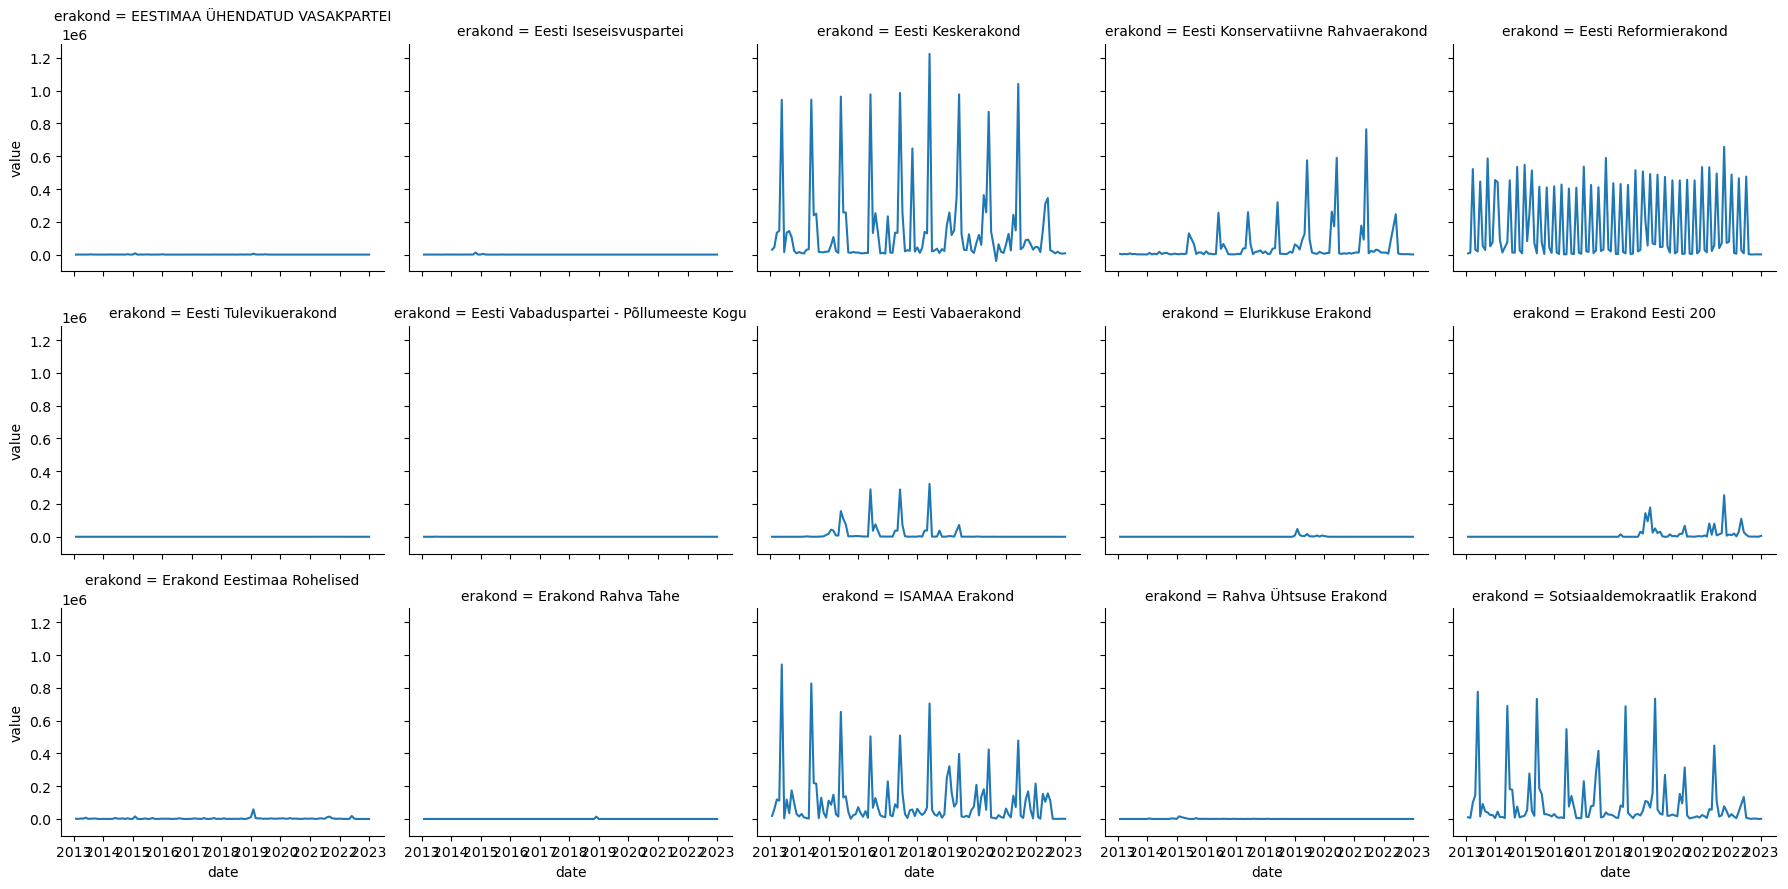

In [12]:
sns.relplot(
    data=df_erakond_m_melt,
    x="date", y="value",
    col="erakond",
    kind="line", col_wrap=5,
    height=3, aspect=1.2, facet_kws=dict(sharex=True),
)

## For further analysis keep erakonnad which have received donations in last year (exclude government donations)

In [13]:
active_parties=(df[df.laekumise_aeg_dt.dt.year==2022].groupby('erakond')['summa'].sum()>10000)
active_parties=active_parties[active_parties].index
active_parties

Index(['Eesti Keskerakond', 'Eesti Konservatiivne Rahvaerakond',
       'Eesti Reformierakond', 'Erakond Eesti 200',
       'Erakond Eestimaa Rohelised', 'ISAMAA Erakond',
       'Sotsiaaldemokraatlik Erakond'],
      dtype='object', name='erakond')

In [14]:
df=df[df.tululiik!='Riigitoetus']
df_active=df[df.erakond.isin(active_parties)]
df_active.shape

(117730, 9)

In [93]:
df_erakond_active_m=df_active.set_index('laekumise_aeg_dt').groupby([pd.Grouper(freq='D'), 'erakond'])['summa'].sum().unstack().fillna(0)
df_erakond_active_m['date']=df_erakond_active_m.index
df_erakond_active_m_melt=df_erakond_active_m.melt(id_vars=['date'])

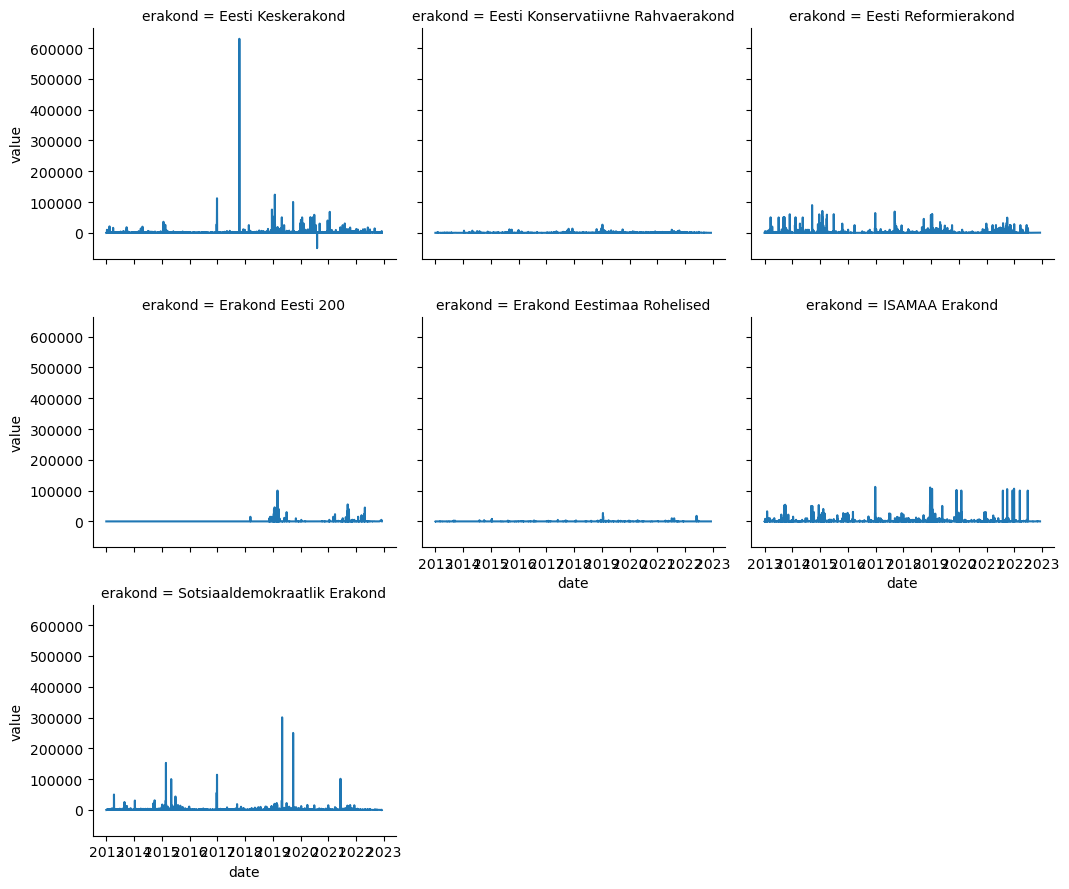

In [94]:
sns.relplot(
    data=df_erakond_active_m_melt,
    x="date", y="value",
    col="erakond",
    kind="line", col_wrap=3,
    height=3, aspect=1.2, facet_kws=dict(sharex=True),
)

## Data for earkonnad

In [95]:
df_erakond_active_m

erakond,Eesti Keskerakond,Eesti Konservatiivne Rahvaerakond,Eesti Reformierakond,Erakond Eesti 200,Erakond Eestimaa Rohelised,ISAMAA Erakond,Sotsiaaldemokraatlik Erakond,date
laekumise_aeg_dt,,,,,,,,
2013-01-01,237.0,0.0,10.0,0.0,10.0,45.0,45.0,2013-01-01
2013-01-02,372.0,0.0,32.0,0.0,320.0,267.0,284.0,2013-01-02
2013-01-03,948.0,200.0,50.0,0.0,70.0,115.0,282.0,2013-01-03
2013-01-04,259.0,96.0,55.0,0.0,40.0,915.0,110.0,2013-01-04
2013-01-05,774.0,309.0,68.0,0.0,10.0,0.0,501.0,2013-01-05
...,...,...,...,...,...,...,...,...
2022-12-02,282.0,137.0,105.0,20.0,0.0,10.0,0.0,2022-12-02
2022-12-03,1384.0,444.0,15.0,0.0,0.0,0.0,0.0,2022-12-03
2022-12-04,5725.0,98.0,45.0,20.0,0.0,125.0,30.0,2022-12-04


## Complete Pooling Model

In complete pooling model for baseline, all data points share single set of parameters $k$ and $m$.

$y(t) \sim N(kt + m, \sigma)$

We used Normal(0, 5) for parameters' prior, which Prophet uses.

In [96]:
complete_pooling_model_code = '''
data {
    int<lower=1> T;
    vector[T] t;
    vector[T] y;
}
parameters {
    real k;
    real m;
    real<lower=0> sigma_obs;
}
transformed parameters {
    vector[T] yhat;
    yhat = k * t + m; 
}
model {
    k ~ normal(0, 5);
    m ~ normal(0, 5);

    y ~ normal(yhat, sigma_obs);
}
generated quantities{
    vector[T] log_lik;
    for (i in 1:T) {
        log_lik[i] = normal_lpdf(y[i]|yhat[i], sigma_obs);
    }
}
'''

## Partial Pooling Model

In partial pooling model, we group data points by periods in seasonality, such as day of the week or day of the month.

Each period $i$ in seasonality has its own set of parameters $k_i$ and $m_i$, and those parameters shares single set of priors $N(\mu_k, \sigma_k)$ and $N(\mu_m, \sigma_m)$. This forms a hierarchical model so parameters can share information through their prior.

$k_i \sim N(\mu_k, \sigma_k)$

$m_i \sim N(\mu_m, \sigma_m)$

$y(t) \sim N(k_it + m_i, \sigma)$

We used proxy variables $p_k$ and $p_m$ to achieve vectorization in likelihood statement.

Priors Normal(0, 5) and Exponential(1) are used for parameters' mean and standard deviation.

In [132]:
partial_pooling_model_code = '''
data {
    int<lower=1> T;
    int<lower=1> P;
    vector[T] t;
    vector[T] y;
    int pool[T];
}
parameters {
    real k_mu;
    real<lower=0> k_sigma;
    real m_mu;
    real<lower=0> m_sigma;
    real k[P];
    real m[P];
    real<lower=0> sigma_obs;
}
transformed parameters {
    vector[T] p_k;
    vector[T] p_m;
    vector[T] yhat;
    for (i in 1:T) {
        p_k[i] = k[pool[i]];
        p_m[i] = m[pool[i]];
    }
    yhat = p_k .* t + p_m;
}
model {
    k_mu ~ normal(0, 5);
    k_sigma ~ exponential(1);
    m_mu ~ normal(0, 5);
    m_sigma ~ exponential(1);

    k ~ normal(k_mu, k_sigma);
    m ~ normal(m_mu, m_sigma);
    sigma_obs ~ normal(0, 0.5);

    y ~ normal(yhat, sigma_obs);
}
generated quantities{
    vector[T] log_lik;
    for (i in 1:T) {
        log_lik[i] = normal_lpdf(y[i]|yhat[i], sigma_obs);
    }
}
'''

## Format data 4 model

In [99]:
t_start = df_erakond_active_m['date'].min()
t_scale = df_erakond_active_m['date'].max() - t_start
df_erakond_active_m['t'] = (df_erakond_active_m['date'] - t_start) / t_scale

In [100]:
erakonnad=['Eesti Keskerakond', 'Eesti Konservatiivne Rahvaerakond',
       'Eesti Reformierakond', 'Erakond Eesti 200',
       'Erakond Eestimaa Rohelised', 'ISAMAA Erakond',
       'Sotsiaaldemokraatlik Erakond']
erakonnad_short={'Eesti Konservatiivne Rahvaerakond':'ekre', 
                'Eesti Reformierakond':'ref',
                'Eesti Keskerakond':'kesk', 
                'Erakond Eesti 200':'e200',
                'ISAMAA Erakond':'isamaa',
                'Sotsiaaldemokraatlik Erakond':'sde',
                 'Erakond Eestimaa Rohelised':'roh'}
df_erakond_active_m.columns=[c if c not in erakonnad_short else erakonnad_short[c] for c in df_erakond_active_m.columns]

In [101]:
df_erakond_active_m_norm.head()

,kesk,ekre,ref,e200,roh,isamaa,sde,t
laekumise_aeg_dt,,,,,,,,
2013-01-31,0.045982,0.072276,0.029632,0.0,0.027107,0.057756,0.030406,0.000000
2013-02-28,0.068596,0.025104,0.045069,0.0,0.006380,0.183801,0.020589,0.007733
2013-03-31,0.026943,0.012769,0.326873,0.0,0.033149,0.052114,0.047166,0.016294
2013-04-30,0.045375,0.018647,0.124648,0.0,0.014701,0.029489,0.175180,0.024579
2013-05-31,0.028714,0.027369,0.077307,0.0,0.013705,0.066122,0.044571,0.033140


In [155]:
def preprocess(df, y_col):
    df['y']=df[y_col]
    df=df.set_index(df['date'])
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.weekday + 1
    df['monthday'] = df['date'].dt.day
    df['week'] = df['date'].dt.week+1
    df['month'] = df['date'].dt.month
    df['year'] = (df['date'].dt.year-df['date'].dt.year.min())+1
    t_start = df['date'].min()
    t_scale = df['date'].max() - t_start
    df['t'] = (df['date'] - t_start) / t_scale
    df['y_scale'] = df['y'].abs().max()
    df['y'] = df['y'] / df['y_scale']
    return df

In [156]:
data_df_dict={er:preprocess(df_erakond_active_m[[er, 'date']], er) for er in erakonnad_short.values() }
len(data_df_dict)

/tmp/ipykernel_79/622979871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y']=df[y_col]
/tmp/ipykernel_79/622979871.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date'].dt.week+1
/tmp/ipykernel_79/622979871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y']=df[y_col]
/tmp/ipykernel_79/622979871.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please us

7

In [157]:
erakond='ref'
df_ref=preprocess(df_erakond_active_m[[erakond, 'date']], erakond)
df_ref.head()

/tmp/ipykernel_79/622979871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y']=df[y_col]
/tmp/ipykernel_79/622979871.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date'].dt.week+1


,ref,date,y,weekday,monthday,week,month,year,t,y_scale
date,,,,,,,,,,
2013-01-01,10.0,2013-01-01,0.000111,2,1,2,1,1,0.000000,90040.0
2013-01-02,32.0,2013-01-02,0.000355,3,2,2,1,1,0.000276,90040.0
2013-01-03,50.0,2013-01-03,0.000555,4,3,2,1,1,0.000552,90040.0
2013-01-04,55.0,2013-01-04,0.000611,5,4,2,1,1,0.000827,90040.0
2013-01-05,68.0,2013-01-05,0.000755,6,5,2,1,1,0.001103,90040.0


<Axes: xlabel='date'>

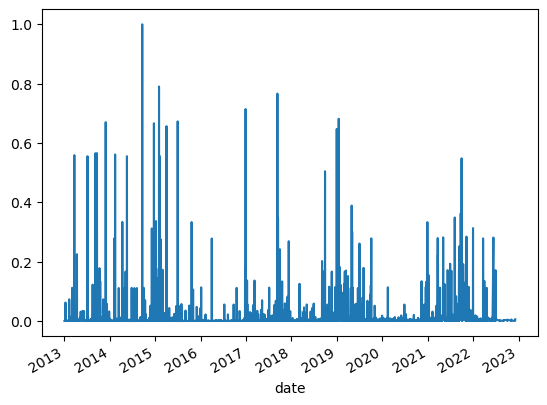

In [158]:
df_ref.y.plot()

In [159]:
def generate_cpm_data(df):
    return {
        'T': df.shape[0],
        't': df['t'].tolist(),
        'y': df['y'].tolist(),
    }

def predict_cpm(params, df):
    df = df.copy()
    df['yhat_cpm'] = params['k'] * df['t'] + params['m']
    return df

def generate_ppm_data(df, pool):
    return {
        'T': df.shape[0],
        'P': df[pool].unique().shape[0],
        't': df['t'].tolist(),
        'y': df['y'].tolist(),
        'pool': df[pool].tolist(),
    }

In [160]:
data_cpm_ref=generate_cpm_data(df_ref)
data_ppm_ref=generate_ppm_data(df_ref, 'year')

In [161]:
def predict_cpm(params, df):
    df = df.copy()
    df['yhat'] = params['k'] * df['t'] + params['m']
    return df

## Train model - ppm

In [162]:
model_ppm_ref=stan.build(program_code=partial_pooling_model_code, data=data_ppm_ref, random_seed=2324)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_pxlg034i/model_6phh3uk5.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_pxlg034i/model_6phh3uk5.stan', line 14, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_pxlg034i/model_6phh3uk5.stan', line 15, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-form

In [163]:
fit_ppm_ref = model_ppm_ref.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2901/8000)
Sampling:  38% (3001/8000)
Sampling:  39% (3101/8000)
Sampling:  40% (3201/8000)
Sampling:  41% (3300/8000)
Samplin

In [165]:
df_fit_ppm_ref=fit_ppm_ref.to_frame()
df_fit_ppm_ref.shape

(4000, 13868)

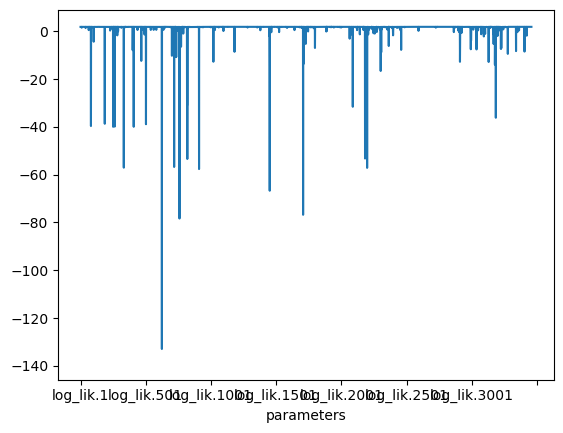

In [167]:
plot_params_ci(df_fit_ppm_ref, 'log_lik')

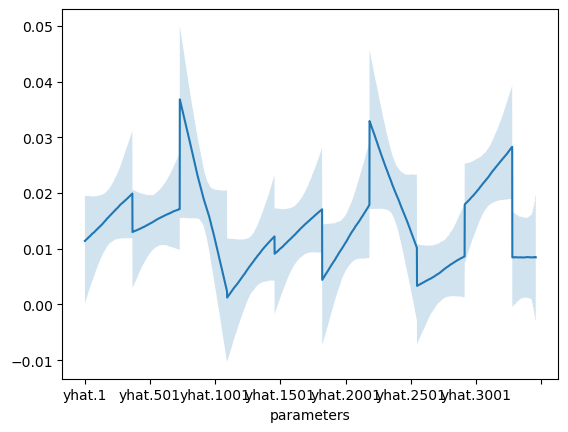

In [168]:
plot_params_ci(df_fit_ppm_ref, 'yhat.')

In [195]:
def predict_ppm(params, df, pool):
    df = df.copy()
    k = np.array([params['k'][i - 1] for i in df[pool]])
    m = np.array([params['m'][i - 1] for i in df[pool]])
    # return k, m
    df['yhat'] = k.mean(axis=1) * df['t'] + m.mean(axis=1)
    return df

In [204]:
df_ref_ppm=predict_ppm(fit_ppm_ref, df_ref, 'year')
df_ref_ppm.shape

(3459, 11)

<Axes: xlabel='date'>

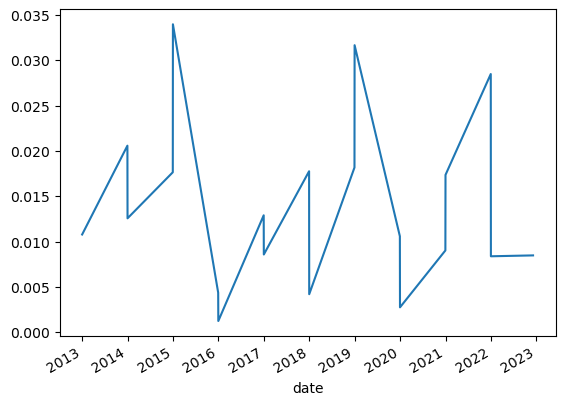

In [194]:
df_ref_ppm.yhat.plot()

<Axes: xlabel='date'>

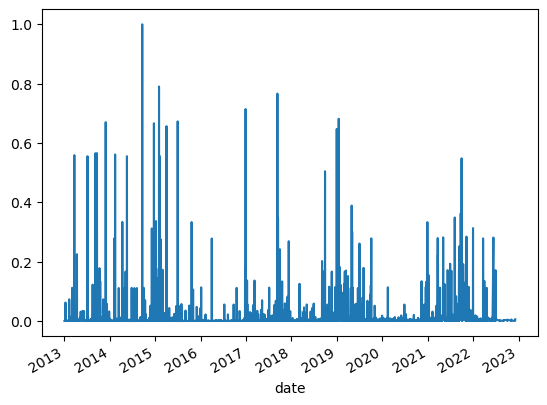

In [184]:
df_ref_ppm.y.plot()

In [ ]:
ppm_mae = np.asarray([
    calculate_mae(predict_ppm(ppm.optimizing(data=generate_ppm_data(train_df, 'weekday'), algorithm='Newton'), test_df, 'weekday'))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])

In [187]:
len(list(generate_cv_data(df_ref, 1, 365)))

9

In [208]:
df_fit_ppm_ref_

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,k_mu,k_sigma,m_mu,m_sigma,k.1,m.1,sigma_obs,p_k.1,p_m.1,yhat.1,log_lik.1
draws,,,,,,,,,,,,,,,,,,
0,-4.156662,0.980025,0.130463,4.0,15.0,0.0,7.638482,-3.282623,0.733647,0.689432,0.324436,-3.989112,0.468171,0.229951,-3.989112,0.468171,0.468171,-1.520633
1,-5.700450,0.847589,0.086743,5.0,31.0,0.0,11.246235,7.040186,1.350560,2.308040,2.260505,6.096395,0.056758,0.082109,6.096395,0.056758,0.056758,1.342793
2,-4.253496,0.421055,0.124352,4.0,15.0,0.0,7.652622,2.154958,2.454150,0.145619,0.103972,1.667233,0.120784,0.068662,1.667233,0.120784,0.120784,0.215247
3,-2.589390,0.984880,0.050741,6.0,127.0,0.0,4.317331,4.250451,0.663529,-0.016294,0.129722,3.154074,0.017205,0.077472,3.154074,0.017205,0.017205,1.614556
4,-2.739056,0.991027,0.130463,4.0,15.0,0.0,6.557431,-4.884534,0.819611,0.517384,0.231873,-4.345433,0.339404,0.458328,-4.345433,0.339404,0.339404,-0.412779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-6.733898,0.998838,0.050741,5.0,63.0,0.0,9.020028,-2.945879,2.113999,-1.437572,0.637291,-6.614369,-0.950483,0.788324,-6.614369,-0.950483,-0.950483,-1.408119
3996,-2.535764,0.935485,0.130463,5.0,31.0,0.0,4.038527,-3.364522,0.897782,0.236984,0.736949,-2.990542,-0.153093,0.174404,-2.990542,-0.153093,-0.153093,0.441611
3997,-4.520975,0.567401,0.086743,4.0,23.0,0.0,9.103905,-2.024122,0.648586,0.277792,2.625458,-1.435184,-0.338904,0.343103,-1.435184,-0.338904,-0.338904,-0.337371


In [209]:
ppm_mae_ref=[]

def predict_ppm_(params, df, pool):
    df = df.copy()
    k = np.array([params['k.1'][i - 1] for i in df[pool]])
    m = np.array([params['m.1'][i - 1] for i in df[pool]])
    # return k, m
    df['yhat'] = k.mean(axis=0) * df['t'] + m.mean(axis=0)
    return df

for train_df_, test_df_ in generate_cv_data(df_ref, 1, 365):
    data_=generate_ppm_data(train_df_, 'year')
    model_ppm_ref_=stan.build(program_code=partial_pooling_model_code, data=data_, random_seed=2324)
    fit_ppm_ref_ = model_ppm_ref_.sample()
    df_fit_ppm_ref_=fit_ppm_ref_.to_frame()
    mae=calculate_mae(predict_ppm_(df_fit_ppm_ref_, test_df_, 'year'))
    ppm_mae_ref.append(mae)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_pxlg034i/model_6phh3uk5.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_pxlg034i/model_6phh3uk5.stan', line 14, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_pxlg034i/model_6phh3uk5.stan', line 15, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-form

In [211]:
np.mean(ppm_mae_ref)

5.365268806381099

## Train model - cpm

In [110]:
model_cpm_ref=stan.build(program_code=complete_pooling_model_code, data=data_cpm_ref, random_seed=2324)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [111]:
fit_cpm_ref = model_cpm_ref.sample()

Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  14% (1100/8000)
Sampling:  22% (1800/8000)
Sampling:  30% (2400/8000)
Sampling:  51% (4100/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.001555 seconds
  1000 transitions using 10 leapfrog steps per transition would take 15.55 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_u2p9pqf8/model_ky3bmox2.stan', line 20, column 4 to column 32)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-c

In [112]:
df_fit_cpm_ref=fit_cpm_ref.to_frame()

In [114]:
def plot_params_ci(df, name_piece):
    df_sub=df[[c for c in df.columns if name_piece in c]]
    lower=np.quantile(df_sub, q=0.05, axis=0)
    upper=np.quantile(df_sub, q=0.95, axis=0)

    ax=df_sub.median(axis=0).plot()
    ax.fill_between(df_sub.columns, lower, upper, alpha=0.2)
    plt.show()

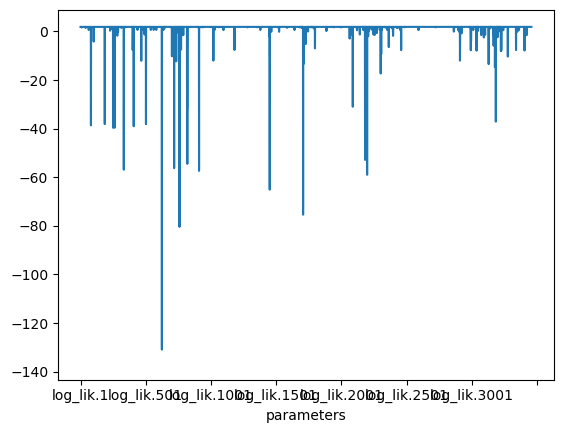

In [115]:
plot_params_ci(df_fit_cpm_ref, 'log_lik')

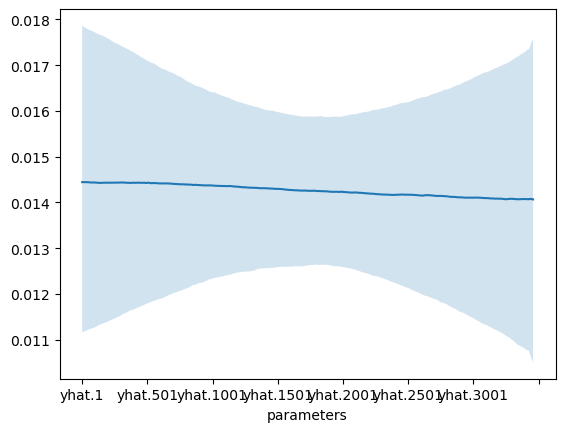

In [116]:
plot_params_ci(df_fit_cpm_ref, 'yhat.')

<Axes: xlabel='laekumise_aeg_dt'>

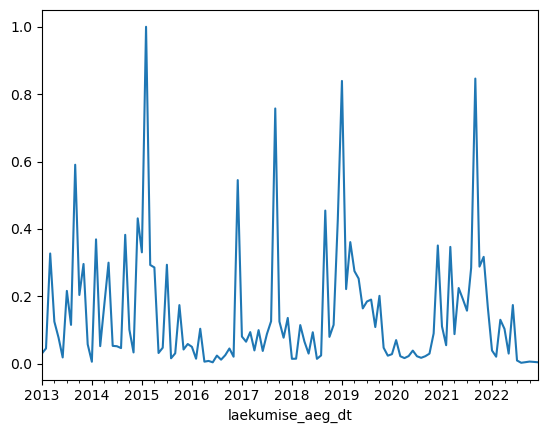

In [117]:
df_erakond_active_m_norm['ref'].plot()

In [118]:
def predict_cpm(params, df):
    df = df.copy()
    df['yhat'] = params['k'].mean() * df['t'] + params['m'].mean()
    return df

def calculate_mae(df):
    y, yhat = df['y'] * df['y_scale'], df['yhat'] * df['y_scale']
    return np.mean(np.abs(y - yhat)) / np.mean(y)

def generate_cv_data(df, initial, horizon):
    n = df.shape[0]
    cutoff = initial
    while cutoff + horizon <= n:
        train_df = df.iloc[:cutoff].reset_index(drop=True)
        test_df = df.iloc[cutoff:cutoff + horizon].reset_index(drop=True)
        yield train_df, test_df
        cutoff += horizon

In [119]:
df_erakond_active_m_norm.shape

(120, 8)

In [120]:
fit_cpm_ref['m'].shape

(1, 4000)

In [121]:
df_ref=predict_cpm(fit_cpm_ref, df_ref)

<Axes: xlabel='date'>

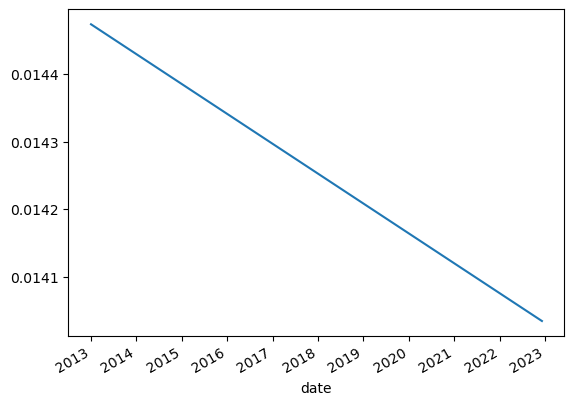

In [122]:
df_ref.yhat.plot()

In [128]:
len(list(generate_cv_data(df_ref, 1, 180)))

19

In [129]:
cpm_mae_ref=[]
for train_df_, test_df_ in generate_cv_data(df_ref, 1, 180):
    data_=generate_cpm_data(train_df_)
    model_cpm_ref_=stan.build(program_code=complete_pooling_model_code, data=data_, random_seed=2324)
    fit_cpm_ref_ = model_cpm_ref_.sample()
    fit_cpm_ref_=fit_cpm_ref_.to_frame()
    mae=calculate_mae(predict_cpm(fit_cpm_ref_, test_df_))
    cpm_mae_ref.append(mae)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_u2p9pqf8/model_ky3bmox2.stan', line 20, column 4 to column 32)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 8.5e-05 seconds
  1000 transitions using 10 leapfrog steps per tran

In [130]:
np.median(cpm_mae_ref)

1.8895574614298243

(array([8., 3., 1., 1., 2., 0., 0., 3., 0., 1.]),
 array([0.98962358, 1.53276389, 2.07590421, 2.61904452, 3.16218484,
        3.70532516, 4.24846547, 4.79160579, 5.33474611, 5.87788642,
        6.42102674]),
 <BarContainer object of 10 artists>)

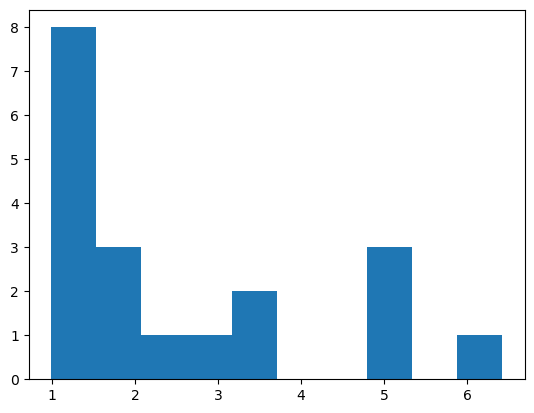

In [131]:
plt.hist(cpm_mae_ref)

In [134]:
def calculate_loo(stan_fit):
    data_ar = az.from_pystan(
        posterior = stan_fit,
        posterior_predictive = ['yhat'],
        observed_data = ['y'],
        log_likelihood='log_lik',
        )
    return az.loo(data_ar)

In [135]:
calculate_loo(fit_cpm_ref)

/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 3459 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  4776.05   278.15
p_loo       42.66        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3455   99.9%
 (0.5, 0.7]   (ok)          3    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1    0.0%

## Train cpm